In [1]:
import msprime, pyslim
import tskit
import json
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
import itertools
import math

import torch
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import os
import gpustat
import pandas as pd
from torch.utils.data import DataLoader, random_split, TensorDataset
from torch import nn
from torchvision.io import read_image
import torchvision.transforms as transforms

import sklearn
import sklearn.model_selection

rng = np.random.default_rng()

In [2]:
stats = gpustat.GPUStatCollection.new_query()
ids = map(lambda gpu: int(gpu.entry['index']), stats)
ratios = map(lambda gpu: float(gpu.entry['memory.used'])/float(gpu.entry['memory.total']), stats)
bestGPU = min(zip(ids, ratios), key=lambda x: x[1])[0]
os.environ['CUDA_VISIBLE_DEVICES'] = str(bestGPU)
print(stats)

GPUStatCollection(host=poppy, [
  [0] NVIDIA A100 80GB PCIe | 30°C,   0 % |     2 / 81920 MB |
  [1] NVIDIA A100 80GB PCIe | 28°C,   0 % |     2 / 81920 MB |
  [2] NVIDIA A100 80GB PCIe | 29°C,   0 % |     2 / 81920 MB |
])


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [4]:
base_folder = "bearded_seals"
labels = pd.read_csv(base_folder + "/labels.csv")
print(labels)

        R0  rep  bias         N_avg     n  npairs
0     8.52    1   1.0   3699.047619  2000     264
1     8.52    1  15.5   3699.047619  2050     291
2     8.52    1  30.0   3699.047619  2050     305
3     8.52    2   1.0   3837.714286  2000     223
4     8.52    2  15.5   3837.714286  2050     278
...    ...  ...   ...           ...   ...     ...
4585  9.90   29  15.5  15106.000000  2050      63
4586  9.90   29  30.0  15106.000000  2050      76
4587  9.90   30   1.0  16121.333333  2000      45
4588  9.90   30  15.5  16121.333333  2050      62
4589  9.90   30  30.0  16121.333333  2050      78

[4590 rows x 6 columns]


bearded_seals/bearded_seal_images/spaghetti_8.52_1_1.0_2000.png
bearded_seals/bearded_seal_images/sampling_intensity_8.52_1_1.0_2000.png


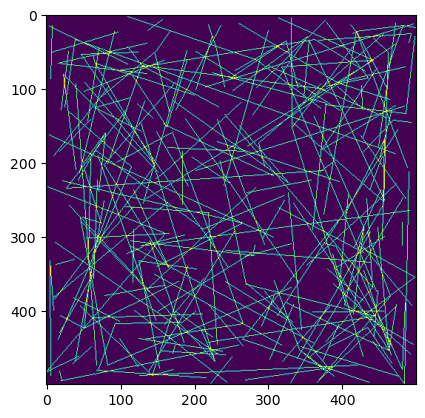

In [5]:
idx = 0
row = labels.iloc[idx,]
R0 = row.loc['R0']
rep = int(row.loc['rep'])
bias = row.loc['bias']
n = int(row.loc['n'])
spaghetti_path = f'{base_folder}/bearded_seal_images/spaghetti_{R0}_{rep}_{bias}_{n}.png'
print(spaghetti_path)
spaghetti = read_image(spaghetti_path)
intensity_path = f'{base_folder}/bearded_seal_images/sampling_intensity_{R0}_{rep}_{bias}_{n}.png'
print(intensity_path)
intensity = read_image(intensity_path)
plt.imshow(spaghetti[0])

In [6]:
print(spaghetti.size())
print(intensity.size())
images = torch.cat((spaghetti, intensity), 0)
print(images.size())

torch.Size([1, 500, 500])
torch.Size([1, 500, 500])
torch.Size([2, 500, 500])


In [7]:
class KinDataset(Dataset):
    def __init__(self, base_folder, labels_file):
        self.labels = pd.read_csv(base_folder + "/" + labels_file)
        self.base_folder = base_folder
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        row = self.labels.iloc[idx,]
        R0 = row.loc['R0']
        rep = int(row.loc['rep'])
        bias = row.loc['bias']
        n = int(2000)
        spaghetti_path = f'{self.base_folder}/bearded_seal_images/spaghetti_{R0}_{rep}_{bias}_{n}.png'
        spaghetti = read_image(spaghetti_path)
        intensity_path = f'{self.base_folder}/bearded_seal_images/sampling_intensity_{R0}_{rep}_{bias}_{n}.png'
        intensity = read_image(intensity_path)
        input_tensor = torch.cat((spaghetti, intensity), 0).float()
        label = torch.tensor([self.labels['N_avg'].iloc[idx]]).float()
        return input_tensor, label
    
kin_dataset = KinDataset("bearded_seals", "labels.csv")

In [8]:
print(kin_dataset[2][0].size())
print(kin_dataset[2][1])
print(kin_dataset[100][1])

torch.Size([2, 500, 500])
tensor([3699.0476])
tensor([4076.5715])


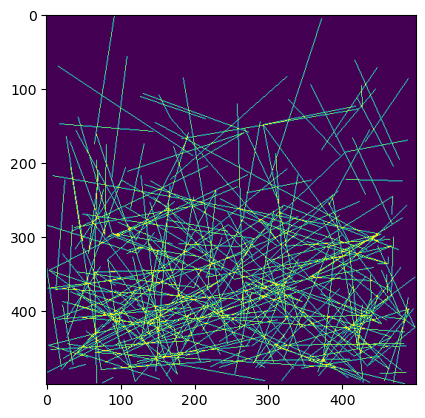

In [9]:
plt.imshow(kin_dataset[2][0][0])

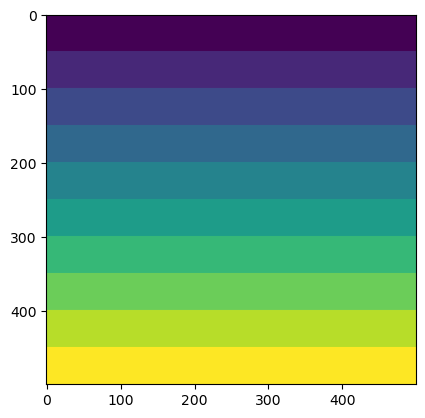

In [10]:
plt.imshow(kin_dataset[2][0][1])

In [11]:
n_total = len(kin_dataset)
n_train = round(n_total*0.5)
n_valid = round((n_total-n_train)*0.5)
n_test = n_total-n_train-n_valid

In [12]:
train_kin, valid_kin, test_kin = random_split(kin_dataset, [n_train, n_valid, n_test], generator=torch.Generator().manual_seed(42))

batch_size = 64
train_kin_dl = DataLoader(train_kin, batch_size, shuffle = True)
valid_kin_dl = DataLoader(valid_kin, batch_size, shuffle = True)
test_kin_dl = DataLoader(test_kin, batch_size, shuffle = True)
print(len(train_kin))
print(len(valid_kin))
print(len(test_kin))

2295
1148
1147


In [13]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=2, out_channels=32, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2)
        self.fc1 = nn.Linear(1000000, 1024)
        self.fc2 = nn.Linear(1024, 1)
        self.dropout = nn.Dropout(p=0.2)
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten() 
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.flatten(x)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

model = Net()
model = model.to(device) 

In [14]:
loss_fn = nn.MSELoss(reduction='mean')

In [15]:
loss_fn = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

def train(model, num_epochs, train_dl, valid_dl):
    loss_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_dl:
            x_batch = x_batch.to(device) 
            y_batch = y_batch.to(device) 
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item()*y_batch.size(0)

        loss_hist_train[epoch] /= len(train_dl.dataset)
        
        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                x_batch = x_batch.to(device) 
                y_batch = y_batch.to(device) 
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                loss_hist_valid[epoch] += loss.item()*y_batch.size(0) 

        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        
        print(f'Epoch {epoch+1} loss: {loss_hist_train[epoch]:.4f} val_loss: {loss_hist_valid[epoch]:.4f}')
    return loss_hist_train, loss_hist_valid

In [16]:
torch.manual_seed(1)
num_epochs = 20
hist = train(model, num_epochs, train_kin_dl, valid_kin_dl)

Epoch 1 loss: 29469526.3983 val_loss: 19654854.1638
Epoch 2 loss: 13340283.7586 val_loss: 9982540.3868
Epoch 3 loss: 5700158.5534 val_loss: 5436213.4059
Epoch 4 loss: 3109986.0248 val_loss: 5284554.1228
Epoch 5 loss: 2102991.3141 val_loss: 5857799.6986
Epoch 6 loss: 1655220.9943 val_loss: 3500639.9321
Epoch 7 loss: 1123773.7822 val_loss: 3423105.9203
Epoch 8 loss: 838608.3226 val_loss: 3557206.1263
Epoch 9 loss: 741593.4382 val_loss: 3479421.6071
Epoch 10 loss: 820296.4185 val_loss: 4528600.2352
Epoch 11 loss: 911380.0459 val_loss: 3701122.9547
Epoch 12 loss: 505175.6904 val_loss: 3686063.4225
Epoch 13 loss: 409888.1438 val_loss: 3465185.4922
Epoch 14 loss: 318427.1165 val_loss: 3538641.6969
Epoch 15 loss: 304110.8653 val_loss: 3479408.8493
Epoch 16 loss: 232031.3548 val_loss: 3558505.3136
Epoch 17 loss: 277368.1510 val_loss: 3543672.0575
Epoch 18 loss: 234559.2304 val_loss: 3657807.8606
Epoch 19 loss: 243123.1281 val_loss: 3684387.1054
Epoch 20 loss: 232702.0877 val_loss: 3752780.2761

In [17]:
#Save model
PATH = "model.pt"
torch.save(model.state_dict(), PATH)

In [16]:
# Load model
PATH = "model.pt"
model = Net()
model.load_state_dict(torch.load(PATH))
model.eval()

Net(
  (conv1): Conv2d(2, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=1000000, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
)

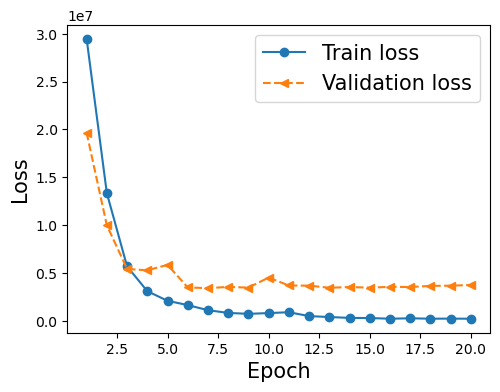

In [18]:
x_arr = np.arange(len(hist[0])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)

plt.show()

In [19]:
torch.cuda.synchronize()
model_cpu = model.cpu()

test_truth = np.empty(len(test_kin))
test_pred = np.empty(len(test_kin))

with torch.no_grad():
    for i, (test_input, test_output) in enumerate(test_kin):
        test_pred[i] = model(test_input.unsqueeze(0))[0][0]
        test_truth[i] = test_output[0]
        #test_pred[i] = test_output.numpy()
        #test_truth[i] = test_output[0].numpy()
        #test_pred[i] = model(test_input)[0, 0].numpy()

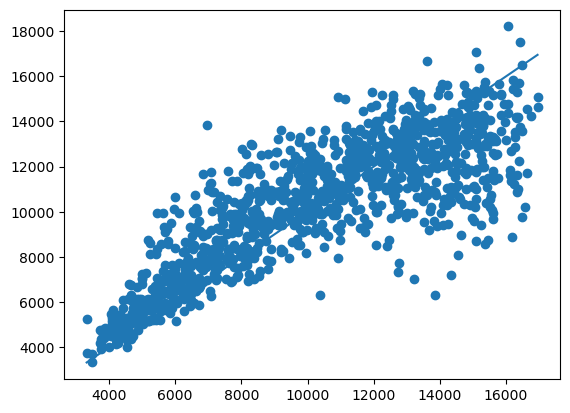

In [20]:
plt.scatter(test_truth, test_pred)
plt.plot([np.min(test_truth), np.max(test_truth)], [np.min(test_truth), np.max(test_truth)])

## How well does the previous model work on the bearded seal sims?

In [21]:
# Create a dataset with only sample locations and spaghetti (because this is what the former model took as input)
class SampleDataset(Dataset):
    def __init__(self, base_folder, labels_file):
        self.labels = pd.read_csv(base_folder + "/" + labels_file)
        self.base_folder = base_folder
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        row = self.labels.iloc[idx,]
        R0 = row.loc['R0']
        rep = int(row.loc['rep'])
        bias = row.loc['bias']
        n = int(2000)
        spaghetti_path = f'{self.base_folder}/bearded_seal_images/spaghetti_{R0}_{rep}_{bias}_{n}.png'
        spaghetti = read_image(spaghetti_path)
        intensity_path = f'{self.base_folder}/bearded_seal_images/samples_{R0}_{rep}_{bias}_{n}.png'
        intensity = read_image(intensity_path)
        input_tensor = torch.cat((spaghetti, intensity), 0).float()
        label = torch.tensor([self.labels['N_avg'].iloc[idx]]).float()
        return input_tensor, label

In [24]:
sample_dataset = SampleDataset("bearded_seals", "labels.csv")

In [31]:
n_total = len(sample_dataset)
# Only test on a subset to make computing predictions faster
n_test = 1000
extra_sample, test_sample = random_split(sample_dataset, [n_total-n_test, n_test], generator=torch.Generator().manual_seed(42))
print(n_total)

4590


torch.Size([2, 500, 500])
tensor([11304.6670])
tensor([12464.9521])


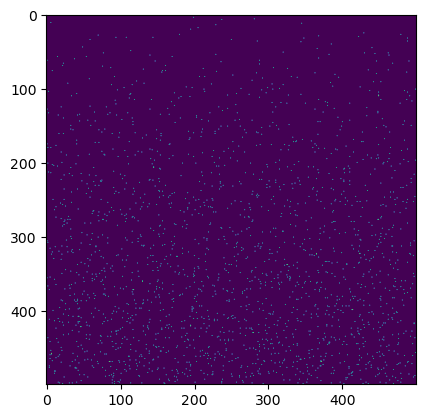

In [32]:
print(test_sample[2][0].size())
print(test_sample[2][1])
print(test_sample[100][1])
plt.imshow(test_sample[2][0][0])
plt.imshow(test_sample[2][0][1])

In [34]:
# Model trained on unbiased sampling
class UnbiasedNet(nn.Module):
    def __init__(self):
        super(UnbiasedNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=2, out_channels=32, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2)
        self.fc1 = nn.Linear(1000000, 1024)
        self.fc2 = nn.Linear(1024, 1)
        self.dropout = nn.Dropout(p=0.2)
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten() 
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.flatten(x)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

PATH = "../close_kin_slim/spaghetti_nn_results/first_model.pt"
unbiased_model = UnbiasedNet()
unbiased_model.load_state_dict(torch.load(PATH))
unbiased_model.eval()

UnbiasedNet(
  (conv1): Conv2d(2, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=1000000, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
)

In [35]:
# Test model on bearded seal data
torch.cuda.synchronize()
model_cpu = model.cpu()

test_truth = np.empty(len(test_sample))
test_pred = np.empty(len(test_sample))

with torch.no_grad():
    for i, (test_input, test_output) in enumerate(sample_dataset):
        test_pred[i] = model(test_input.unsqueeze(0))[0][0]
        test_truth[i] = test_output[0]

IndexError: index 1000 is out of bounds for axis 0 with size 1000

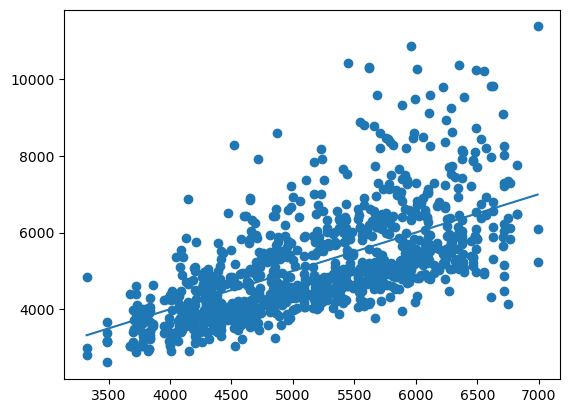

In [36]:
plt.scatter(test_truth, test_pred)
plt.plot([np.min(test_truth), np.max(test_truth)], [np.min(test_truth), np.max(test_truth)])